In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

# ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

In [3]:
gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

In [4]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

In [5]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [6]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [7]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation)

In [8]:
ultra_ga = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
# ultra = ultra_ga.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
#     .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [35]:
#Adding tide
import glob
import pandas as pd

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

path = r'C:/Users/arj26323/Documents/Data/flats/Tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)
df_time = df2[time_mask]

df_time

# print(df_time.dtypes)

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,1985/01/02,2024-04-08 16:00:00,0.340,-,0.479,1985-01-02
40,1985/01/03,2024-04-08 16:00:00,0.275,-,0.406,1985-01-03
64,1985/01/04,2024-04-08 16:00:00,0.374,-,0.458,1985-01-04
88,1985/01/05,2024-04-08 16:00:00,0.620,-,0.543,1985-01-05
112,1985/01/06,2024-04-08 16:00:00,0.967,-,1.162,1985-01-06
...,...,...,...,...,...,...
350536,1984/12/28,2024-04-08 16:00:00,1.759,-,1.83,1984-12-28
350560,1984/12/29,2024-04-08 16:00:00,1.466,-,1.449,1984-12-29
350584,1984/12/30,2024-04-08 16:00:00,1.148,-,1.104,1984-12-30
350608,1984/12/31,2024-04-08 16:00:00,0.835,-,0.927,1984-12-31


In [36]:
##GEORGIA
#LOW: < 0.8
#Mid: 0.8-1.8
#High: > 1.8

##MASSACHUSETTS
# LOW: < 1.17
# Mid: 1.17-2.5
# High: > 2.5


##VIRGINIA
# LOW: < 0.331
# Mid: 0.331-0.698
# High: > 0.698

In [59]:
# Get the image IDs and acquisition dates separately
image_ids = ultra_ga.aggregate_array('system:id').getInfo()
acquisition_dates = ultra_ga.aggregate_array('system:time_start').getInfo()

# Create the DataFrame
dfx = pd.DataFrame({'Image': image_ids, 'acquisition_date': acquisition_dates})

dfx['Date'] = pd.to_datetime(dfx['acquisition_date'], unit='ms')
dfx['DOY'] = dfx['Date'].dt.strftime('%Y-%m-%d')
dfx['DOY'] = pd.to_datetime(dfx['DOY'])

df_u = pd.merge(dfx, df_time, on = 'DOY')

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

# Display the DataFrame
# print(dfx)
# print(df_u)

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

df_low = df_u[df_u['Verified (m)'] <= 0.8]
df_mid = df_u[df_u['Verified (m)'].between(0.8, 1.8)]
df_high = df_u[df_u['Verified (m)'] >= 1.8]

# print(df_high)

                                            Image  acquisition_date  \
13    LANDSAT/LC08/C02/T1_L2/LC08_016038_20131021     1382370985700   
14    LANDSAT/LC08/C02/T1_L2/LC08_016038_20131106     1383753382163   
34    LANDSAT/LC08/C02/T1_L2/LC08_016038_20141211     1418313281678   
52    LANDSAT/LC08/C02/T1_L2/LC08_016038_20151128     1448726086462   
53    LANDSAT/LC08/C02/T1_L2/LC08_016038_20151214     1450108484983   
...                                           ...               ...   
2351  LANDSAT/LC09/C02/T1_L2/LC09_016038_20230110     1673366103297   
2362  LANDSAT/LC09/C02/T1_L2/LC09_016038_20230806     1691337262659   
2370  LANDSAT/LC09/C02/T1_L2/LC09_017038_20211107     1636300764429   
2371  LANDSAT/LC09/C02/T1_L2/LC09_017038_20220420     1650470434233   
2381  LANDSAT/LC09/C02/T1_L2/LC09_017038_20221013     1665676873638   

                      Date_x        DOY      Date_y          Time (GMT)  \
13   2013-10-21 15:56:25.700 2013-10-21  2013/10/21 2024-04-08 16:00:00 

In [77]:
#Slope of flats, by pixel

# Create a list of image names
low_names = df_low['Image'].tolist()
mid_names = df_mid['Image'].tolist()
high_names = df_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = low_names

'''
NOTE WHICH TIDE THIS BE
'''

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5).map(add_elevation)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7).map(add_elevation)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8).map(add_elevation)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9).map(add_elevation)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

study_area = flux_ga.geometry()

col = col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50)).filterBounds(study_area)

''' 
ABOVE IS WHERE YOU ADJUST THE YEAR TO PARSE THIS OUT BY DECADE - BE AWARE OF THE DATES
'''

# Function to calculate linear regression for each pixel
def add_time(image):
    # Add a band representing time in years
    time = image.metadata('system:time_start').divide(31536000000)  # milliseconds to years
    return image.addBands(time.rename('time'))

colx = col.map(add_time)

# Perform linear regression for each pixel
linearFit = colx.select(['time', 'flats']).reduce(
        reducer=ee.Reducer.linearFit()
    )

In [71]:
#Directory
out_dir = os.path.join("F:/Flats imagery/Tide stage composites/Decadal/GA") ##NOTE WHERE THIS BE
##Draw geometry for exported images! It will look better

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

image = linearFit
filename = os.path.join(out_dir, 'low_84_23.tif') ##NOTE WHICH TIDE AND DECADEs

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('scale'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

Generating URL ...
Please wait ...
Data downloaded to F:\Flats imagery\Tide stage composites\Decadal\GA


In [13]:
Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

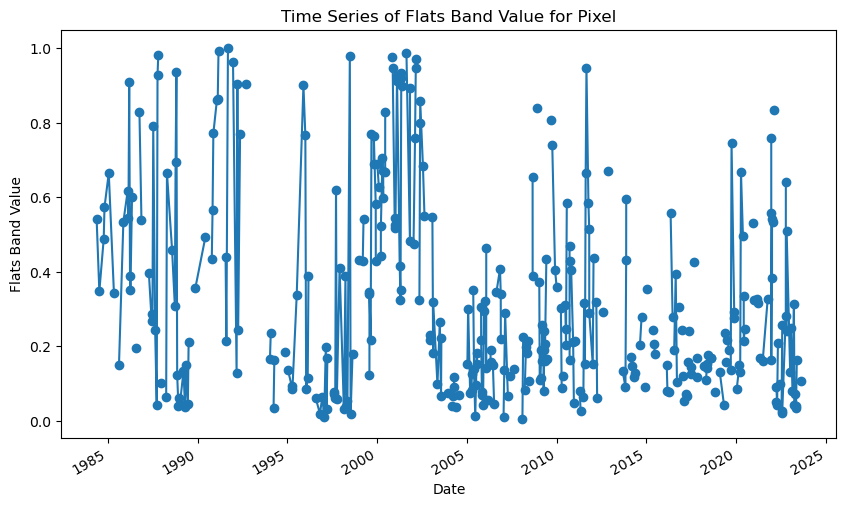

In [78]:
#Creating a time series for a single point - check tide division above.

point = ee.Geometry.Point(-81.2835 , 31.4441)

# Function to extract time series data for one pixel
def extract_pixel_time_series(image):
    value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30)
    return ee.Feature(None, {'flats': value})

# Map the function over the collection to get the time series
time_series = col.map(extract_pixel_time_series)

# Extract 'flats' band values from the time series
flats_series = time_series.aggregate_array('flats')

# Convert the time series to a list
flats_list = flats_series.getInfo()

# Extract 'flats' value from the dictionary-like list
flats_values = [x['flats'] for x in flats_list]

# Extract dates
dates = col.aggregate_array('system:time_start').getInfo()

# Convert dates to pandas datetime
dates = pd.to_datetime(dates, unit='ms')

# Create a pandas DataFrame
df = pd.DataFrame({'Date': dates, 'Flats': flats_values})

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
df['Flats'].plot(marker='o', linestyle='-')
plt.title('Time Series of Flats Band Value for Pixel')
plt.xlabel('Date')
plt.ylabel('Flats Band Value')
plt.grid(False)
plt.show()

In [79]:
df

,Flats
Date,
1984-04-12 15:21:47.367,NaN
1984-05-14 15:22:12.295,0.541033
1984-10-05 15:24:43.558,0.487819
1984-10-21 15:24:40.071,0.573397
1985-05-01 15:24:47.850,0.343538
...,...
2022-06-23 16:00:39.280,NaN
2022-07-25 16:00:46.956,0.256451
2023-02-18 16:01:11.781,0.079728


In [76]:
# df

# vis_nir = {
#     "bands": ["SR_B5", "SR_B4", "SR_B3"],
#     "min": 0.0,
#     "max": 0.3,
# }

# xxx = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20230813')))
# Map.addLayer(xxx, vis_nir, 'something off')
# Map

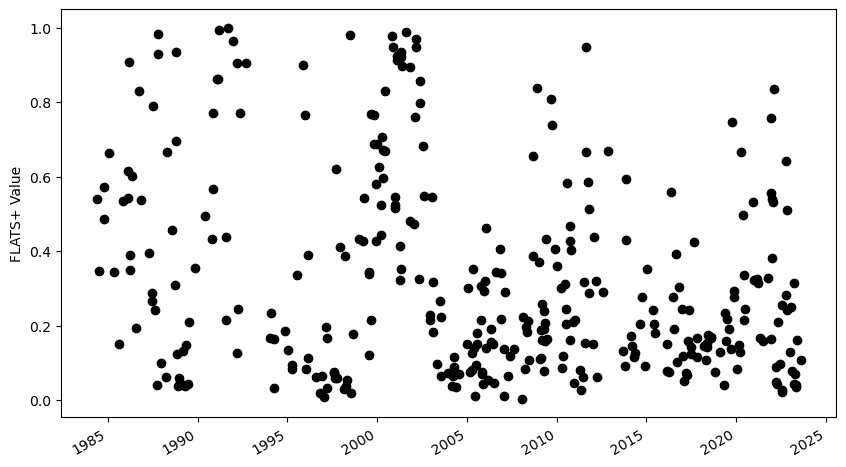

In [80]:
# Plot the time series
plt.figure(figsize=(10, 6))
df['Flats'].plot(marker='o', linestyle='', color = 'black')
plt.xlabel('')
plt.ylabel('FLATS+ Value')
plt.grid(False)

# plt.savefig('pixeltrend.png', bbox_inches='tight', dpi = 300)

plt.show()

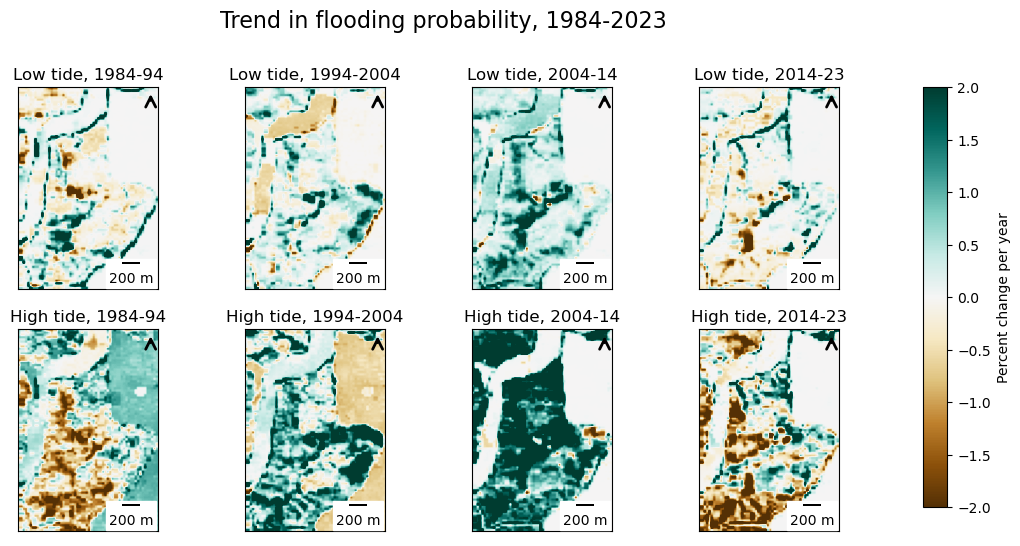

In [2]:
#FLATS COLOR PERCENTAGE PLOTTING

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_84 = "F:/Flats imagery/Tide stage composites/Decadal/GA/high_84_94.scale.tif"
h_94 = "F:/Flats imagery/Tide stage composites/Decadal/GA/high_94_04.scale.tif"
h_04 = "F:/Flats imagery/Tide stage composites/Decadal/GA/high_04_14.scale.tif"
h_14 = "F:/Flats imagery/Tide stage composites/Decadal/GA/high_14_23.scale.tif"

l_84 = "F:/Flats imagery/Tide stage composites/Decadal/GA/low_84_94.scale.tif"
l_94 = "F:/Flats imagery/Tide stage composites/Decadal/GA/low_94_04.scale.tif"
l_04 = "F:/Flats imagery/Tide stage composites/Decadal/GA/low_04_14.scale.tif"
l_14 = "F:/Flats imagery/Tide stage composites/Decadal/GA/low_14_23.scale.tif"

slope_paths = [l_84, l_94, l_04, l_14, h_84, h_94, h_04, h_14]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values
        data_normalized = (data) / (1)*100
        
        cmap = 'BrBG'
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-2, vmax=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(2, 4, figsize=(12, 6))  # Adjusted figsize

ims = []
titles = ['Low tide, 1984-94','Low tide, 1994-2004','Low tide, 2004-14','Low tide, 2014-23',\
          'High tide, 1984-94','High tide, 1994-2004','High tide, 2004-14','High tide, 2014-23']

data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in flooding probability, 1984-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Percent change per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('percentslopes_trend.png',bbox_inches='tight', dpi = 300)

plt.show()

In [18]:
##VA

bbva = ee.Geometry.Polygon([[-75.87, 37.2], [-75.87, 37.235], [-75.85, 37.235], [-75.85, 37.2]])

bbma = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

In [19]:
vcr_shp = 'F:/Wetlands shapefiles/VA_MA_FLATS/VCR_2.shp'
pie_shp = 'F:/Wetlands shapefiles/VA_MA_FLATS/pie.shp'

vcr = geemap.shp_to_ee(vcr_shp)
pie = geemap.shp_to_ee(pie_shp)

## DEM
vcr_elevation = ee.Image('USGS/3DEP/10m').clip(vcr) ##This is 1/3 arc second, or 10 m.
pie_elevation = ee.Image('USGS/3DEP/10m').clip(pie) ##This is 1/3 arc second, or 10 m.

In [20]:
#Loading gee datasets - VCR
l8_vcr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(vcr) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_vcr = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(vcr)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_vcr = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(vcr)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_vcr = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(vcr)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)

#Loading gee datasets - PIE
l8_pie = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(pie) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_pie = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(pie)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_pie = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(pie)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_pie = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(pie)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)

In [21]:
#Adding tide - MA
import glob
import pandas as pd

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

path = r'F:\Wetlands shapefiles\VA_MA_FLATS\MA_tides' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)
ma_time = df2[time_mask]

ma_time['Verified (m)'] = ma_time['Verified (m)'].replace('-', float('nan')).astype('float')
ma_time = ma_time.dropna()

ma_time

# ma_time['Verified (m)'].quantile(0.33)
# print(ma_time.dtypes)

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,2005/01/01,2024-04-08 16:00:00,1.246,-,1.168,2005-01-01
40,2005/01/02,2024-04-08 16:00:00,0.825,-,0.894,2005-01-02
64,2005/01/03,2024-04-08 16:00:00,0.490,-,0.469,2005-01-03
88,2005/01/04,2024-04-08 16:00:00,0.378,-,0.402,2005-01-04
112,2005/01/05,2024-04-08 16:00:00,0.544,-,0.520,2005-01-05
...,...,...,...,...,...,...
350536,2004/12/27,2024-04-08 16:00:00,2.972,-,3.283,2004-12-27
350560,2004/12/28,2024-04-08 16:00:00,2.759,-,2.351,2004-12-28
350584,2004/12/29,2024-04-08 16:00:00,2.417,-,2.348,2004-12-29
350608,2004/12/30,2024-04-08 16:00:00,2.020,-,2.030,2004-12-30


In [22]:
#Adding tide - VA
import glob
import pandas as pd

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

path = r'F:\Wetlands shapefiles\VA_MA_FLATS\VA_tides' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)
va_time = df2[time_mask]

va_time['Verified (m)'] = va_time['Verified (m)'].replace('-', float('nan')).astype('float')
va_time = va_time.dropna()

va_time
# va_time['Verified (m)'].quantile(0.67)

# print(df_time.dtypes)

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,2001/01/01,2024-04-08 16:00:00,0.566,-,0.224,2001-01-01
40,2001/01/02,2024-04-08 16:00:00,0.425,-,0.315,2001-01-02
64,2001/01/03,2024-04-08 16:00:00,0.276,-,0.277,2001-01-03
88,2001/01/04,2024-04-08 16:00:00,0.140,-,0.132,2001-01-04
112,2001/01/05,2024-04-08 16:00:00,0.040,-,-0.015,2001-01-05
...,...,...,...,...,...,...
341776,2000/12/27,2024-04-08 16:00:00,0.738,-,0.446,2000-12-27
341800,2000/12/28,2024-04-08 16:00:00,0.781,-,0.759,2000-12-28
341824,2000/12/29,2024-04-08 16:00:00,0.787,-,0.711,2000-12-29
341848,2000/12/30,2024-04-08 16:00:00,0.755,-,0.958,2000-12-30


In [23]:

ultra_vcr = l8_vcr.merge(l5_vcr).merge(l7_vcr).merge(l9_vcr)
ultra_pie = l8_pie.merge(l5_pie).merge(l7_pie).merge(l9_pie)

##VCR
# Get the image IDs and acquisition dates separately
v_image_ids = ultra_vcr.aggregate_array('system:id').getInfo()
v_acquisition_dates = ultra_vcr.aggregate_array('system:time_start').getInfo()

# Create the DataFrame
v_dfx = pd.DataFrame({'Image': v_image_ids, 'acquisition_date': v_acquisition_dates})

v_dfx['Date'] = pd.to_datetime(v_dfx['acquisition_date'], unit='ms')
v_dfx['DOY'] = v_dfx['Date'].dt.strftime('%Y-%m-%d')
v_dfx['DOY'] = pd.to_datetime(v_dfx['DOY'])

v_df_u = pd.merge(v_dfx, va_time, on = 'DOY')

v_df_u['Verified (m)'] = v_df_u['Verified (m)'].replace('-', float('nan')).astype('float')

# Display the DataFrame
# print(dfx)
# print(df_u)

v_df_u['Verified (m)'] = v_df_u['Verified (m)'].replace('-', float('nan')).astype('float')

va_low = v_df_u[v_df_u['Verified (m)'] <= 0.331]
va_mid = v_df_u[v_df_u['Verified (m)'].between(0.331, 0.698)]
va_high = v_df_u[v_df_u['Verified (m)'] >= 0.698]

# print(va_high)


##PIE
# Get the image IDs and acquisition dates separately
m_image_ids = ultra_pie.aggregate_array('system:id').getInfo()
m_acquisition_dates = ultra_pie.aggregate_array('system:time_start').getInfo()

# Create the DataFrame
m_dfx = pd.DataFrame({'Image': m_image_ids, 'acquisition_date': m_acquisition_dates})

m_dfx['Date'] = pd.to_datetime(m_dfx['acquisition_date'], unit='ms')
m_dfx['DOY'] = m_dfx['Date'].dt.strftime('%Y-%m-%d')
m_dfx['DOY'] = pd.to_datetime(m_dfx['DOY'])

m_df_u = pd.merge(m_dfx, ma_time, on = 'DOY')

m_df_u['Verified (m)'] = m_df_u['Verified (m)'].replace('-', float('nan')).astype('float')

# Display the DataFrame
# print(dfx)
# print(df_u)

m_df_u['Verified (m)'] = m_df_u['Verified (m)'].replace('-', float('nan')).astype('float')

ma_low = m_df_u[m_df_u['Verified (m)'] <= 0.331]
ma_mid = m_df_u[m_df_u['Verified (m)'].between(0.331, 0.698)]
ma_high = m_df_u[m_df_u['Verified (m)'] >= 0.698]

# print(ma_high)

In [24]:
#VCR -- Slope of flats, by pixel, by decade

bbva = ee.Geometry.Polygon([[-75.89, 37.21], [-75.89, 37.165], [-75.81, 37.165], [-75.81, 37.21]])
# bbva = ee.Geometry.Polygon([[-75.92, 37.21], [-75.92, 37.155], [-75.81, 37.155], [-75.81, 37.21]]) ##LARGE scale

# Create a list of image names
low_names = va_low['Image'].tolist()
mid_names = va_mid['Image'].tolist()
high_names = va_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = high_names

''' 
NOTE WHICH TIDE IT BE
'''

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

study_area = vcr.geometry()

col = col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bbva)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50)).filterBounds(study_area)

''' 
ABOVE IS WHERE YOU ADJUST THE YEAR TO PARSE THIS OUT BY DECADE - BE AWARE OF THE DATES
'''

# Function to calculate linear regression for each pixel
def add_time(image):
    # Add a band representing time in years
    time = image.metadata('system:time_start').divide(31536000000)  # milliseconds to years
    return image.addBands(time.rename('time'))

colx = col.map(add_time)

# Perform linear regression for each pixel
linearFit = colx.select(['time', 'flats']).reduce(
        reducer=ee.Reducer.linearFit()
    )

In [25]:
#Directory
out_dir = os.path.join("F:/Flats imagery/Tide stage composites/Decadal/VA")

image = linearFit
filename = os.path.join(out_dir, 'high_84_94.tif')

image = image.clip(bbva).unmask()

# geemap.ee_export_image(
#     image.select('scale'), filename=filename, scale=30, region=bbva, file_per_band=True
# )

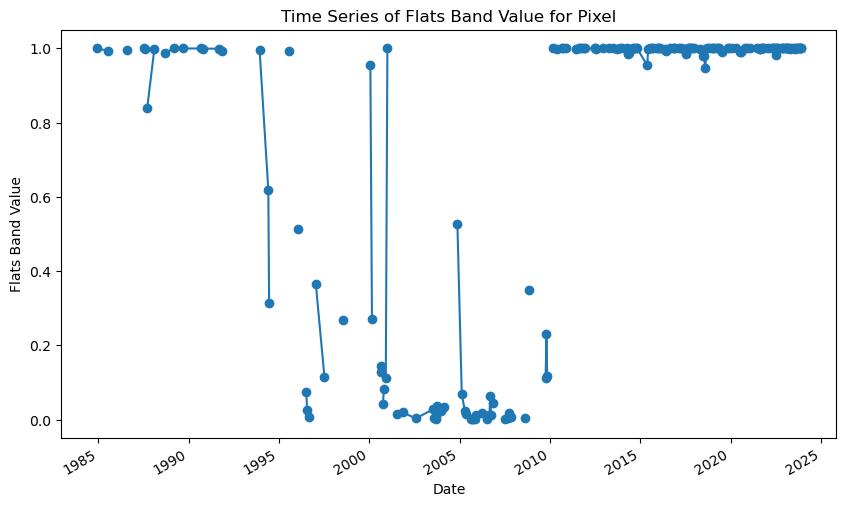

In [26]:
#Creating a time series for a single point

point = ee.Geometry.Point(-75.82931, 37.178974)

# Function to extract time series data for one pixel
def extract_pixel_time_series(image):
    value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30)
    return ee.Feature(None, {'flats': value})

# Map the function over the collection to get the time series
time_series = col.map(extract_pixel_time_series)

# Extract 'flats' band values from the time series
flats_series = time_series.aggregate_array('flats')

# Convert the time series to a list
flats_list = flats_series.getInfo()

# Extract 'flats' value from the dictionary-like list
flats_values = [x['flats'] for x in flats_list]

# Extract dates
dates = col.aggregate_array('system:time_start').getInfo()

# Convert dates to pandas datetime
dates = pd.to_datetime(dates, unit='ms')

# Create a pandas DataFrame
df = pd.DataFrame({'Date': dates, 'Flats': flats_values})

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
df['Flats'].plot(marker='o', linestyle='-')
plt.title('Time Series of Flats Band Value for Pixel')
plt.xlabel('Date')
plt.ylabel('Flats Band Value')
plt.grid(False)
plt.show()

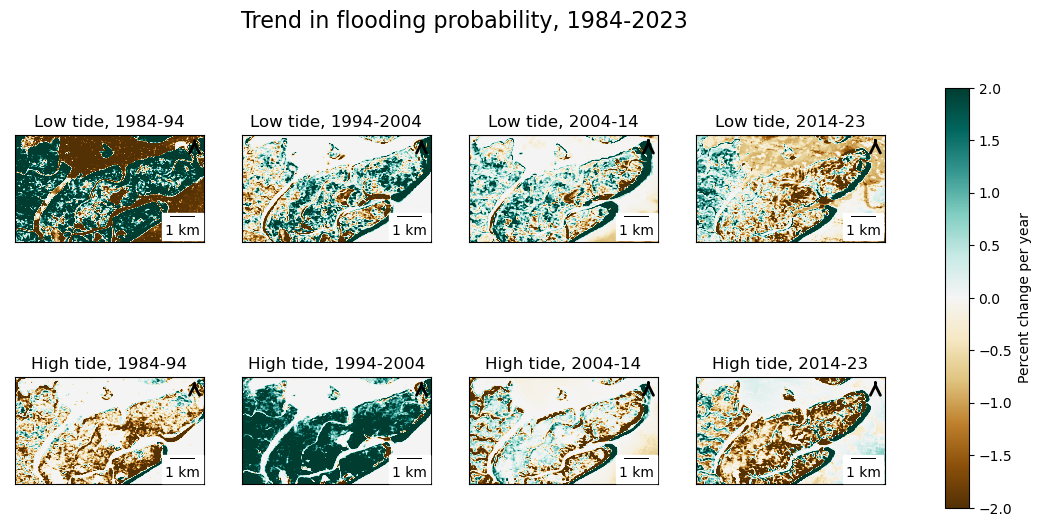

In [27]:
#FLATS COLOR PERCENTAGE PLOTTING

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_84 = "F:/Flats imagery/Tide stage composites/Decadal/VA/high_84_94.scale.tif"
h_94 = "F:/Flats imagery/Tide stage composites/Decadal/VA/high_94_04.scale.tif"
h_04 = "F:/Flats imagery/Tide stage composites/Decadal/VA/high_04_14.scale.tif"
h_14 = "F:/Flats imagery/Tide stage composites/Decadal/VA/high_14_23.scale.tif"

l_84 = "F:/Flats imagery/Tide stage composites/Decadal/VA/low_84_94.scale.tif"
l_94 = "F:/Flats imagery/Tide stage composites/Decadal/VA/low_94_04.scale.tif"
l_04 = "F:/Flats imagery/Tide stage composites/Decadal/VA/low_04_14.scale.tif"
l_14 = "F:/Flats imagery/Tide stage composites/Decadal/VA/low_14_23.scale.tif"

slope_paths = [l_84, l_94, l_04, l_14, h_84, h_94, h_04, h_14]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values
        data_normalized = (data) / (1)*100
        
        cmap = 'BrBG'
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-2, vmax=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(2, 4, figsize=(12, 6))  # Adjusted figsize

ims = []
titles = ['Low tide, 1984-94','Low tide, 1994-2004','Low tide, 2004-14','Low tide, 2014-23',\
          'High tide, 1984-94','High tide, 1994-2004','High tide, 2004-14','High tide, 2014-23']

data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in flooding probability, 1984-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Percent change per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('percentslopes_trend.png',bbox_inches='tight', dpi = 300)

plt.show()

In [28]:
#PIE -- Slope of flats, by pixel

bbma = ee.Geometry.Polygon([[-70.8, 42.75], [-70.8, 42.8], [-70.86, 42.8], [-70.86, 42.75]])

# Create a list of image names
low_names = ma_low['Image'].tolist()
mid_names = ma_mid['Image'].tolist()
high_names = ma_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = low_names
''' 
NOTE WHICH TIDE IT BE
'''

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

study_area = pie.geometry()

col = col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bbma)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50)).filterBounds(study_area)
''' 
ABOVE IS WHERE YOU ADJUST THE YEAR TO PARSE THIS OUT BY DECADE - BE AWARE OF THE DATES
'''

# Function to calculate linear regression for each pixel
def add_time(image):
    # Add a band representing time in years
    time = image.metadata('system:time_start').divide(31536000000)  # milliseconds to years
    return image.addBands(time.rename('time'))

colx = col.map(add_time)

# Perform linear regression for each pixel
linearFit = colx.select(['time', 'flats']).reduce(
        reducer=ee.Reducer.linearFit()
    )

In [29]:
#Directory
out_dir = os.path.join("F:/Flats imagery/Tide stage composites/Decadal/MA")
##Draw geometry for exported images! It will look better

bbma = ee.Geometry.Polygon([[-70.8, 42.75], [-70.8, 42.8], [-70.86, 42.8], [-70.86, 42.75]])

image = linearFit
filename = os.path.join(out_dir, 'low_84_94.tif')

image = image.clip(bbma).unmask()

# geemap.ee_export_image(
#     image.select('scale'), filename=filename, scale=30, region=bbma, file_per_band=True
# )

In [30]:
Map

Map(bottom=107150.0, center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent…

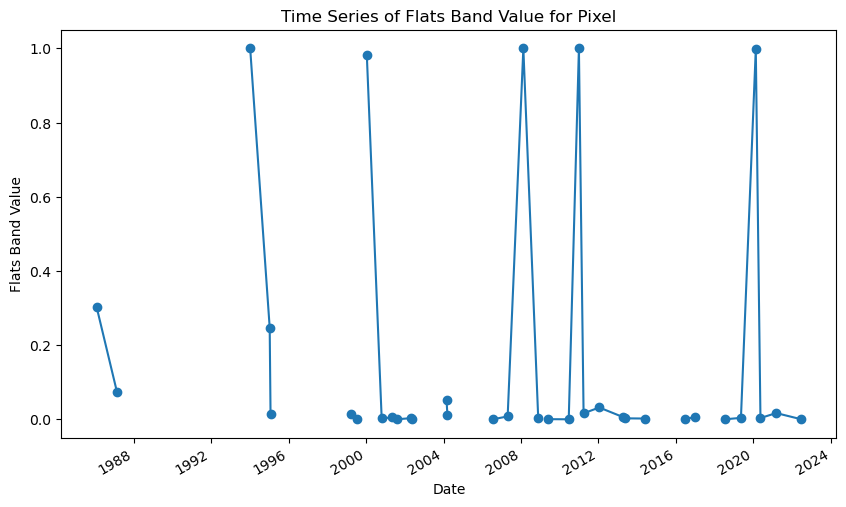

In [31]:
#Creating a time series for a single point

point = ee.Geometry.Point(-70.82271, 42.76629)

# Function to extract time series data for one pixel
def extract_pixel_time_series(image):
    value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30)
    return ee.Feature(None, {'flats': value})

# Map the function over the collection to get the time series
time_series = col.map(extract_pixel_time_series)

# Extract 'flats' band values from the time series
flats_series = time_series.aggregate_array('flats')

# Convert the time series to a list
flats_list = flats_series.getInfo()

# Extract 'flats' value from the dictionary-like list
flats_values = [x['flats'] for x in flats_list]

# Extract dates
dates = col.aggregate_array('system:time_start').getInfo()

# Convert dates to pandas datetime
dates = pd.to_datetime(dates, unit='ms')

# Create a pandas DataFrame
df = pd.DataFrame({'Date': dates, 'Flats': flats_values})

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
df['Flats'].plot(marker='o', linestyle='-')
plt.title('Time Series of Flats Band Value for Pixel')
plt.xlabel('Date')
plt.ylabel('Flats Band Value')
plt.grid(False)
plt.show()

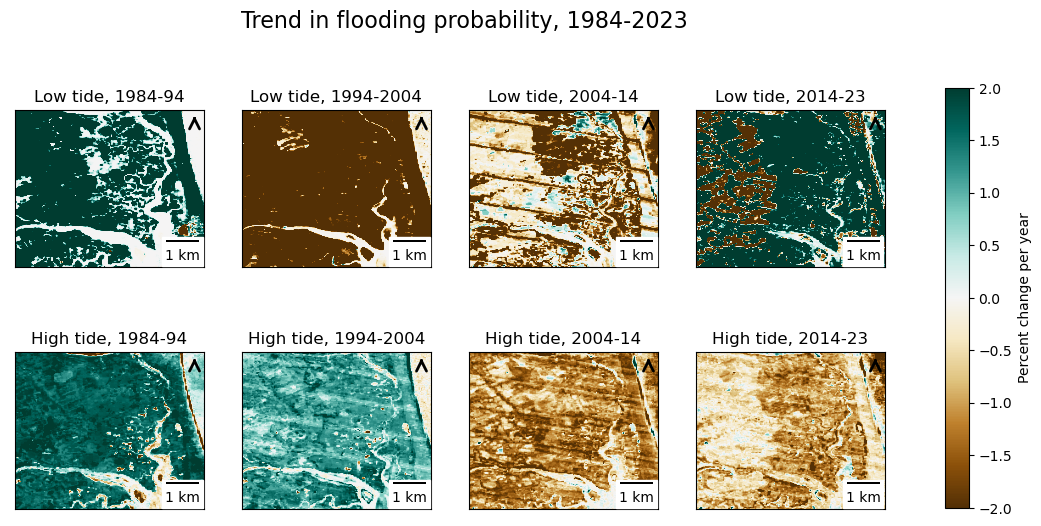

In [32]:
#FLATS COLOR PERCENTAGE PLOTTING

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_84 = "F:/Flats imagery/Tide stage composites/Decadal/MA/high_84_94.scale.tif"
h_94 = "F:/Flats imagery/Tide stage composites/Decadal/MA/high_94_04.scale.tif"
h_04 = "F:/Flats imagery/Tide stage composites/Decadal/MA/high_04_14.scale.tif"
h_14 = "F:/Flats imagery/Tide stage composites/Decadal/MA/high_14_23.scale.tif"

l_84 = "F:/Flats imagery/Tide stage composites/Decadal/MA/low_84_94.scale.tif"
l_94 = "F:/Flats imagery/Tide stage composites/Decadal/MA/low_94_04.scale.tif"
l_04 = "F:/Flats imagery/Tide stage composites/Decadal/MA/low_04_14.scale.tif"
l_14 = "F:/Flats imagery/Tide stage composites/Decadal/MA/low_14_23.scale.tif"

slope_paths = [l_84, l_94, l_04, l_14, h_84, h_94, h_04, h_14]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values
        data_normalized = (data) / (1)*100
        
        cmap = 'BrBG'
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-2, vmax=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(2, 4, figsize=(12, 6))  # Adjusted figsize

ims = []
titles = ['Low tide, 1984-94','Low tide, 1994-2004','Low tide, 2004-14','Low tide, 2014-23',\
          'High tide, 1984-94','High tide, 1994-2004','High tide, 2004-14','High tide, 2014-23']

data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in flooding probability, 1984-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Percent change per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('percentslopes_trend.png',bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
#Something seems very off, with all of these decadal patterns. Could be how the linearFit() function works?